# Autograd

PyTorch has built-in gradient descent mechanism called "autograd". This comes in handy as we do not need to input the jacobian in function minimizers.

Consider the following toy example of temperature between two separate detectors/instruments.

In [1]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import torch

import torch.nn.functional

In [3]:
# Celsius
tem_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
tem_c_t = torch.tensor(tem_c)

# Unknown
tem_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
tem_u_t = torch.tensor(tem_u)

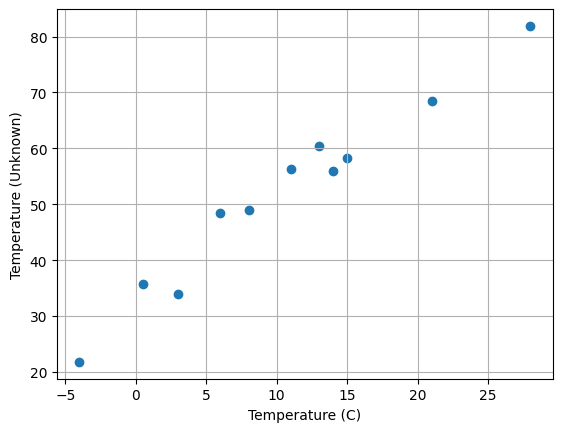

In [7]:
fig_tem, ax_tem = plt.subplots()

ax_tem.scatter(
    tem_c,
    tem_u
)
ax_tem.grid(True)
ax_tem.set_xlabel("Temperature (C)")
ax_tem.set_ylabel("Temperature (Unknown)")
plt.show(fig_tem)

The data relationship certainly looks linear. Can we calculate function $f = f(t_C)$ where $f = w t_C + b$ and $f$ predicts $t_U$. To do this, let's use the `torch.nn.functional` module to define theobjective/loss function.

In [9]:
mse_loss = torch.nn.functional.mse_loss

To calculate the parameters `(w, b)`, I will instantiate a tensor with gradient tracking using `requires_grad=True` in the constructor.

In [35]:
params: torch.Tensor = torch.tensor([1.0, 0.01], requires_grad=True)

Now the model function takes a tensor and two scaler parameters.

To utilize "autograd", we need to call the `torch.Tensor.backward` method on the loss function in the training loop.

__WARNING__: Calling backward will lead derivatives to accumulate at leaf nodes. We need to zero the gradient explicitly after using it for parameter updates.

To address this issue in PyTorch, we zero the gradient during the training loop using `grad.zero_()`.
There is also a curious context

```python
with torch.no_grad():
    params -= learning_rate * params.grad
```

Taken from the book

```
This means within the with block, the PyTorch autograd mechanism should _look away_ that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that PyTorch records is consumed when we call backward, leaving us with the params leaf node.
```



In [41]:
def model(x_t, weight, bias):
    """Linear model using scaler weight and bias

    Parameters
    ----------
    x_t : torch.Tensor
        Input tensor
    weight : float
        Weight floating point number
    bias : float
        Bias floating point number

    Returns
    -------
        torch.Tensor
    """
    return weight * x_t + bias


def training_loop(
    n_epochs,
    learning_rate,
    params,
    t_u,
    t_c
):
    """Training loop for toy temperature data

    Parameters
    ----------
    n_epochs : int
        Number of iterations
    learning_rate : float
        How steep of steps
    params : torch.Tensor
        Parameter tensor
    t_u : torch.Tensor
        Unknown temperature tensor
    t_c : torch.Tensor
        Target known temperature tensor

    Returns
    -------
    torch.Tensor
        Parameter tensor
    """
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = mse_loss(t_p, t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
            if epoch % 100 == 0 or epoch < 5:
                print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params


training_loop(
    200,
    1e-2,
    torch.tensor([1.0, 0.01], requires_grad=True),
    tem_u_t,
    tem_c_t
)

Epoch 1, Loss 1764.710815
Epoch 2, Loss 5805146.500000
Epoch 3, Loss 19416940544.000000
Epoch 4, Loss 64945718820864.000000
Epoch 100, Loss nan
Epoch 200, Loss nan


tensor([nan, nan], requires_grad=True)

Looks like the loss diverged! This is a typical problem in minimization problems. This is due to that the input data are not normalized relative and the learning rate is too high.

Let's try to decrease the rate.

In [43]:
training_loop(
    200,
    1e-5,
    torch.tensor([1.0, 0.01], requires_grad=True),
    tem_u_t,
    tem_c_t
)

Epoch 1, Loss 1764.710815
Epoch 2, Loss 1566.496948
Epoch 3, Loss 1390.920410
Epoch 4, Loss 1235.395630
Epoch 100, Loss 29.145098
Epoch 200, Loss 29.125328


tensor([ 0.2321, -0.0096], requires_grad=True)

Great, that seems to have fixed the divergence.